In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind, mode
from sklearn import preprocessing
import math

In [2]:
# Так графики выглядят более приятно 
import warnings; warnings.simplefilter('ignore')
sns.set()

In [3]:
pd.set_option('display.max_rows', None) # Показывать больше строк
pd.set_option('display.max_columns', None) # Показывать больше колонок

In [4]:
sm = pd.read_csv('stud_math.csv')

In [5]:
sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Согласно .info() у нас 13 числовых параметров и 17 категориальных. Также согласно описанию, видно, что некоторые категориальные даннеы имеют только 2 варината результатов это "да" или "нет", вполне возможно их надо будет выделить в 3 группу параметров.

__________________________________________________

In [6]:
sm.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


# Предобработка датасета

### Пользовательские функции

In [7]:
def empty_count(df_name, col):
    
    ''' 
    Функция принимает на вход датасет (df_name), колонку (col)
    
    и расчитывает количество значений Nan и их процент в Серии
    
    '''
    name = col # Имя колонки для принта
    
    data_mis_mean = df_name[col].isna().mean()
    data_mis_sum = df_name[col].isna().sum()
    
    print('В колонке {} - {} % пропусков, это {} значений Nan'.format(name,
                                                                      round((data_mis_mean*100), 1),
                                                                      data_mis_sum))
    
    
    
    
def boxan(df, met, main_met, descr):
    
    ''' 
    Функция для построения боксплота.
    
    Принимает на вход датасет (df), колонку (met),
    
    ключевую метрику (main_met), описание графика (descr),
    
    и строит боксплот
    
    '''
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    axes.set_ylim(-1,110)
    
    sns.boxplot(x=df[met], y=df[main_met])
    axes.set_xlabel(descr)
    axes.set_ylabel('Оценка по экзамену') # В рамках этого EDA
        
        
def desc_obj(df_col_name):
    ''' 
    Функция для замены значений NaN на моду 
    
    в колонках с категориальными данными
    
    '''
    des = df_col_name.describe(include=['object'])
    df_col_name.fillna(des['top'], inplace=True)
    

def get_box(df, column_1, column_2, column_3, column_4, met):
    ''' 
    Функция для рисования бокплотов по 4 в ряд. 
    
    Убодно для наглядности. 
    
    met - ключевая переменная
    
    '''
    name_1 = column_1
    name_2 = column_2
    name_3 = column_3
    name_4 = column_4
    
    # Первый бокс
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    axes.set_ylim(-1,110)
    
    sns.boxplot(x = df[column_1], y = df[met])
    axes.set_xlabel(name_1)
    axes.set_ylabel('Оценка по экзамену')
    
    # Второй бокс
    axes2 = fig.add_axes([1.2, 0, 1, 1])
    axes2.set_ylim(-1,110)
    
    sns.boxplot(x = df[column_2], y = df[met])
    axes2.set_xlabel(name_2)
    axes2.set_ylabel('Оценка по экзамену')
    
    
    # Третий бокс
    axes3 = fig.add_axes([2.4, 0, 1, 1])
    axes3.set_ylim(-1,110)
    
    sns.boxplot(x = df[column_3], y = df[met])
    axes3.set_xlabel(name_3)
    axes3.set_ylabel('Оценка по экзамену')
    
    # Четвертый бокс
    axes4 = fig.add_axes([3.6, 0, 1, 1])
    axes4.set_ylim(-1,110)
    
    sns.boxplot(x = df[column_4], y = df[met])
    axes4.set_xlabel(name_4)
    axes4.set_ylabel('Оценка по экзамену')
    
    # Так более информативно
    print(df[column_1].value_counts())
    print(df[column_2].value_counts())
    print(df[column_3].value_counts())
    print(df[column_4].value_counts())

def get_stat_dif1(df, column, met=''):
    ''' 
    Функция для поиска статистически значимых переменных,
    
    цифра 1 означает, что это проверка выполнятеся ДО замены 
    
    Nan на моду, медиану и т.д. 
    
    Значения Nan - удаляются.
    
    '''
    
    a =True # Флаг для команды print если таких значений нет
    
    for_stat = df.dropna() # Очистим данные от пустых значений для поиска
    
    cols = for_stat.loc[:, column]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(for_stat.loc[for_stat.loc[:, column] == comb[0], met], 
                        for_stat.loc[for_stat.loc[:, column] == comb[1], met]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            
            print('Найдены статистически значимые различия для колонки', column)
            
            a = False
            
            break
    
    if a == True:
        print('Cтатистически значимые различия для колонки {} не найдены'.format(column))
    else:
        return   
    
    
    
def get_stat_dif2(df, column, met=''):
    ''' 
    Функция для поиска статистически значимых переменных,
    
    цифра 2 означает, что это проверка выполнятеся ПОСЛЕ замены 
    
    Nan на моду, медиану и т.д. 
            
    '''
    
    a =True # Флаг для команды print если таких значений нет
    
    for_stat = df # Датафрейм уже долже быть без Nan, замененных модой, медианой и т.д.
    
    cols = for_stat.loc[:, column]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(for_stat.loc[for_stat.loc[:, column] == comb[0], met], 
                        for_stat.loc[for_stat.loc[:, column] == comb[1], met]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            
            print('Найдены статистически значимые различия для колонки', column)
            
            a = False
            
            break
    
    if a == True:
        print('Cтатистически значимые различия для колонки {} не найдены'.format(column))
    else:
        return
    

def rew_num_moda(df_col_name):
    ''' 
    Функция для замены значений NaN на моду 
    
    в колонках с количественными данными
    
    '''
        
    des = df_col_name.describe()
    df_col_name.fillna(des['50%'], inplace=True)
    

#### Внимание!

Функция проверки метрики на стат. значимость может потребовать времени на расчет.

Название некоторых колонок начинается с большой буквы. Приведем все к общему виду (в данном случае название колонки в нижнем ригистре):

In [8]:
sm.columns = sm.columns.str.lower()    

И для удобства переименуем колонку studytime, granular 

In [9]:
sm.rename(columns={'studytime, granular':'studytime_s'}, inplace=True)

_______________________________________________________________________________________________________________________

# Целевая метрика 
В данном датасете целевой метрекой является - score - количество баллов за тест по математике.

Сразу посмотрим на нее. Ее распределение, пропуски, выбросы. 

Так как это особенная метрика - она длжна содержать только истинные метки. Поэтому пустые значения удаляются, а не заменяются на вероятностные. 


In [10]:
empty_count(sm, 'score')

В колонке score - 1.5 % пропусков, это 6 значений Nan


Удалим строки с пропущенными значениями:

In [11]:
sm.dropna(subset=['score'], inplace=True)
empty_count(sm, 'score')

В колонке score - 0.0 % пропусков, это 0 значений Nan


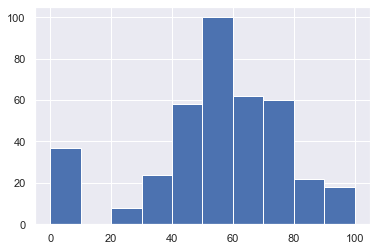

In [12]:
sm.score.hist(bins=10)

In [13]:
sm.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

Метрика распределена почти нормально, однако видно несколько значений равных 0. Таких значений 37. Обратим внимание, что мньше 20 баллов оценок нет (кроме 0). 

Судя по графику в тесте используется 100 бальная система. Значит есть какой-то минимум, чтобы можно было считать, что тест пройден. Можно сделать вывод, что 20 баллов это и есть этот минимум, а ученики набравшие меньше 20 получают оценку 0 (хотя значение оценки может быть от 5 до 15 (судя по всему оценка ведется "пятерками")). 

Следовательно, ученики набравшие 0 баллов за тест, скорее всего либо на него не пришли (отказались его проходить) либо получили менее 20 баллов. Но точная причина получения оценки равно 0 нам не известа.


In [14]:
sm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   school       389 non-null    object 
 1   sex          389 non-null    object 
 2   age          389 non-null    int64  
 3   address      374 non-null    object 
 4   famsize      362 non-null    object 
 5   pstatus      344 non-null    object 
 6   medu         386 non-null    float64
 7   fedu         365 non-null    float64
 8   mjob         370 non-null    object 
 9   fjob         353 non-null    object 
 10  reason       372 non-null    object 
 11  guardian     358 non-null    object 
 12  traveltime   361 non-null    float64
 13  studytime    382 non-null    float64
 14  failures     367 non-null    float64
 15  schoolsup    380 non-null    object 
 16  famsup       351 non-null    object 
 17  paid         350 non-null    object 
 18  activities   375 non-null    object 
 19  nursery 

_______________________________________________________________________________________________________________________

## Первичный анализ данных в столбцах.

Посчитаем пропуски и выведем процент пропусков на колонку

In [16]:
for col in sm.columns:
    pct_missing = sm[col].isna().mean()
    print('{} - {}%'.format(col, round((pct_missing*100), 1)))
    

school - 0.0%
sex - 0.0%
age - 0.0%
address - 3.9%
famsize - 6.9%
pstatus - 11.6%
medu - 0.8%
fedu - 6.2%
mjob - 4.9%
fjob - 9.3%
reason - 4.4%
guardian - 8.0%
traveltime - 7.2%
studytime - 1.8%
failures - 5.7%
schoolsup - 2.3%
famsup - 9.8%
paid - 10.0%
activities - 3.6%
nursery - 3.9%
studytime_s - 1.8%
higher - 5.1%
internet - 8.7%
romantic - 8.0%
famrel - 6.9%
freetime - 2.3%
goout - 1.8%
health - 3.9%
absences - 2.8%
score - 0.0%


Посмотрим признаки, где процент пропусков больше 10%

In [17]:
for col in sm.columns:
    pct_missing = sm[col].isna().mean()
    if round((pct_missing*100), 1)>=10:
        print('{} - {}%'.format(col, round((pct_missing*100), 1)))

pstatus - 11.6%
paid - 10.0%


Вывод: пропуски есть. Самые большие (10% и более) это признаки "pstatus" - статус совместного жилья родителей, и "paid" - дополнительные платные занятия по математике.
       Стоит обратить внимание на "paid" - возможно это один из ключевых признаков.

Посчитаем пропущеннеы значения по строкам

In [18]:
mis = sm.isnull().sum(axis=1).value_counts().reset_index()
mis.rename(columns={'index':'nan', 0:'num_nan'}, inplace=True)
mis 



,nan,num_nan
0,1,130
1,2,97
2,0,97
3,3,43
4,4,15
5,5,5
6,6,2


2 строки имеют 6 пропусков из 30, и еще 5 строк по 5 пропусков. Это 7 максимально неинформативных строк, заполнение значениями которых, может привести к искажению целевой метрики. Удалим их.

In [19]:
sm.dropna(thresh=26, inplace=True) # удалячем те строки где количество значений не NaN, не менее 26
mis = sm.isnull().sum(axis=1).value_counts().reset_index()
mis.rename(columns={'index':'nan', 0:'num_nan'}, inplace=True)
mis 

,nan,num_nan
0,1,130
1,2,97
2,0,97
3,3,43
4,4,15


### Информация о столбце "school" (аббревиатура школы)

Согласно инфо. данные в этой колонке не содержат пропущеных значений.

Узнаем сколько уникальных значений в колонке

In [20]:
empty_count(sm, 'school')

В колонке school - 0.0 % пропусков, это 0 значений Nan


In [21]:
sm.school.nunique()

2

In [22]:
sm.school.value_counts()

GP    337
MS     45
Name: school, dtype: int64

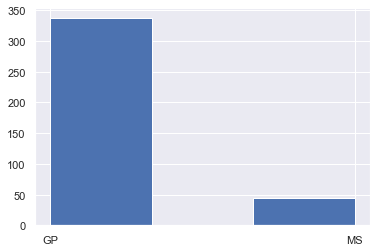

In [23]:
sm.school.hist(bins=3)

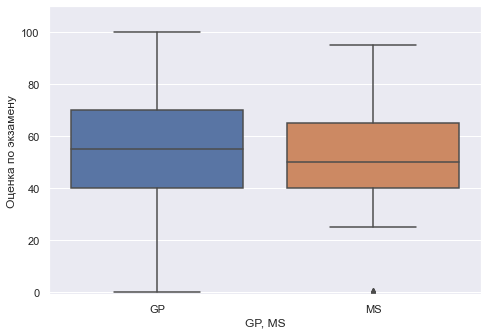

In [24]:
boxan(sm, 'school', 'score', 'GP, MS')

Всего 2 школы. 

Чтобы все остальные признаки имели ранвый вес для анализа, эти школы должны находится в одном регионе (страна, город и т.п.) поэтому сейчас можно предположить, что название школы не влияет на успеваемость. Для школы MS оценка 0 считатся вбросом.

In [25]:
get_stat_dif2(sm, 'school', met='score')

Cтатистически значимые различия для колонки school не найдены


#########################################################################################################################

### Информация о столбце "sex" (пол ученика)

Всего 2 школы. 

Чтобы все остальные признаки имели ранвый вес для анализа, эти школы должны находится в одном регионе (страна, город и т.п.) поэтому сейчас можно предположить, что название школы не влияет на успеваемость. Для школы MS оценка 0 считатся вбросом.

In [26]:
empty_count(sm, 'sex')

В колонке sex - 0.0 % пропусков, это 0 значений Nan


In [27]:
sm.sex.value_counts()

F    201
M    181
Name: sex, dtype: int64

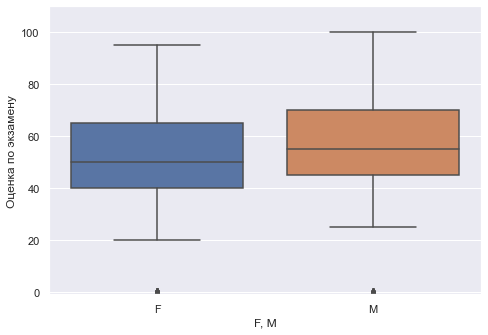

In [28]:
boxan(sm, 'sex', 'score', 'F, M')

In [29]:
get_stat_dif2(sm, 'sex', met='score')

Cтатистически значимые различия для колонки sex не найдены


Пропусков нет, мальчиков и девочек почти равное количество. Оценка 0 считается допустимым вбросом. 

На целевую переменную не влияет 

#########################################################################################################################

### Информация о столбце "age" (возраст ученика)

In [39]:
empty_count(sm, 'age')

В колонке age - 0.0 % пропусков, это 0 значений Nan


Столбец чиловой, пропусков нет. Можно посмотреть на его распределение

In [31]:
sm.age.value_counts()

16    102
17     95
15     81
18     79
19     20
20      3
22      1
21      1
Name: age, dtype: int64

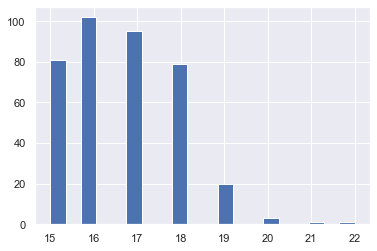

In [32]:
sm.age.hist(bins=20)

In [33]:
sm.age.describe()

count    382.000000
mean      16.667539
std        1.266132
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Медианный возраст 17 лет. Большинство учеников соотвествуют возрасту старшей школы.
Однако, в дальнешем стоит обратить внимание на учеников чей возраст от 20 до 22, который соотвествует возрасту высшей школы, где уровень знаний отличается. 

Проверим нет ли вбросов с помощью боксплота.

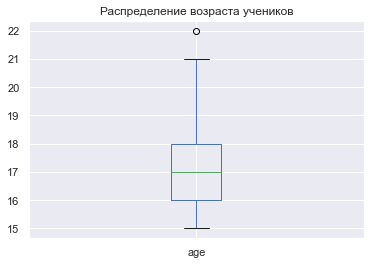

In [34]:
sm.age.plot(kind='box',
            title="Распределение возраста учеников")

Возраст равный 22 годам выходит за пределы межквартильного размаха и считается вбросом. Удалим его. Скорее всего это второгодка. 

In [35]:
sm.drop(sm[sm.age == 22].index, inplace=True)

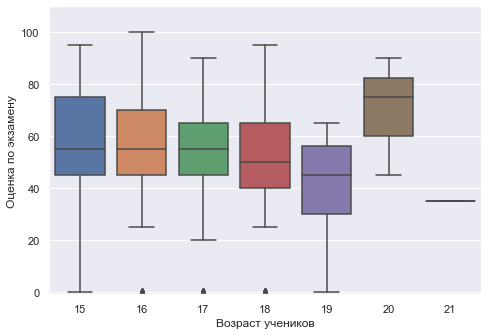

In [36]:
boxan(sm, 'age', 'score', 'Возраст учеников')

Возраст равный 21 году малоиформативен. Удалим его. 



In [37]:
sm.drop(sm[sm.age == 21].index, inplace=True)

Вывод:Оценка равная 0 для учеников с 16 по 18 лет считается допустимым вбросом. 

#########################################################################################################################

### Информация о столбце "address" (тип адреса (город, за городом))

In [40]:
empty_count(sm, 'address')

В колонке address - 3.9 % пропусков, это 15 значений Nan


In [41]:
sm.address.value_counts()

U    283
R     82
Name: address, dtype: int64

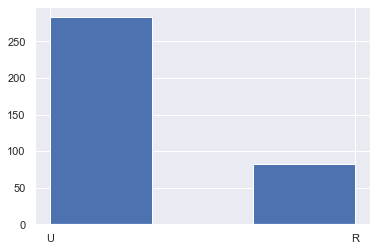

In [42]:
sm.address.hist(bins=3)

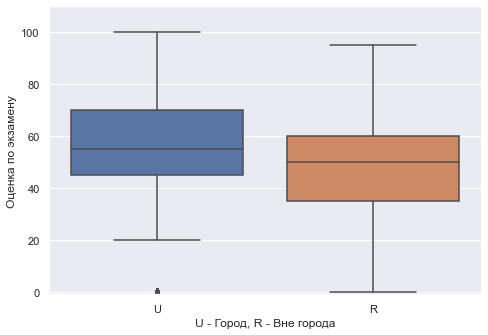

In [43]:
boxan(sm, 'address', 'score', 'U - Город, R - Вне города')

Медианное значение оценки по экзамену примерно одинаково как для городских, так и для учеников живущих за городом. Однако, для учеников из города оценка 0 считается вбросом.

До заполнения проверим метрику на стат.значимость (без Nan):


In [44]:
get_stat_dif1(sm, 'address', met='score')

Cтатистически значимые различия для колонки address не найдены


Не обнаружено. Заменим Nan на моду и проверим еще раз.

In [45]:
sm["address"].fillna('U', inplace=True)

In [46]:
get_stat_dif2(sm, 'address', met='score')

Cтатистически значимые различия для колонки address не найдены


Около 80% учеников из датасета проживают в городе.

Вывод: Место жительства не оказывает влияния на оценку по экзамену. 

#########################################################################################################################

### Информация о столбце "famsize" (размер семьи('LE3' <= 3, 'GT3' >3))

In [47]:
empty_count(sm, 'famsize')

В колонке famsize - 6.3 % пропусков, это 24 значений Nan


In [48]:
sm.famsize.value_counts()

GT3    251
LE3    105
Name: famsize, dtype: int64

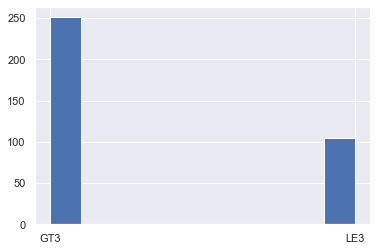

In [49]:
sm.famsize.hist()

Посмотрим есть ли явная зависимость оценок по математики от размера семьи:

In [50]:
a =  sm.groupby(['famsize'])['score'].agg(['min', 'max', 'mean']).reset_index()
a

,famsize,min,max,mean
0,GT3,0.0,100.0,51.573705
1,LE3,0.0,95.0,54.523810


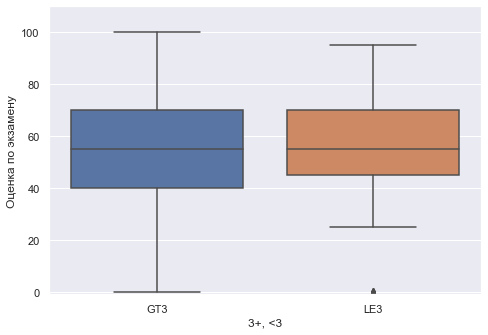

In [51]:
boxan(sm, 'famsize', 'score', '3+, <3')

Явной зависимости нет. 

Промерим на стат. значимость (без Nan)


In [52]:
get_stat_dif1(sm, 'famsize', met='score')

Cтатистически значимые различия для колонки famsize не найдены


Не обнаружено. Заменим Nan модой и промерим еще раз. 

In [53]:
desc_obj(sm.famsize)

In [54]:
get_stat_dif2(sm, 'famsize', met='score')

Cтатистически значимые различия для колонки famsize не найдены


Вывод: Медианное значение оценки по экзамену примерно одинаково для любого состава семьи.
Не влияет на целевую переменную.

#########################################################################################################################

### Информация о столбце "pstatus" (статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно))

In [55]:
empty_count(sm, 'pstatus')

В колонке pstatus - 10.3 % пропусков, это 39 значений Nan


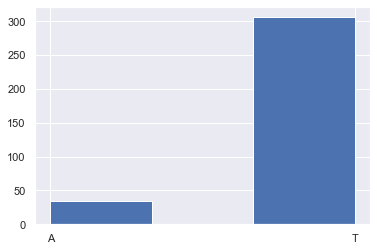

In [56]:
sm.pstatus.hist(bins=3)

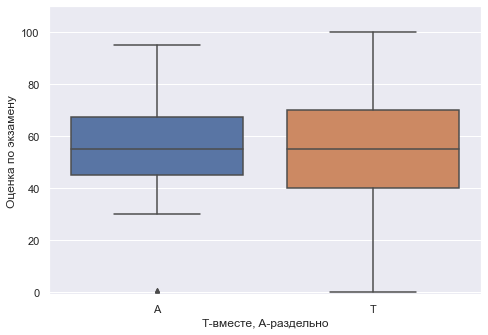

In [57]:
boxan(sm, 'pstatus', 'score', 'T-вместе, A-раздельно')

У подавляющего большинства учеников роители живут вместе. 

Промерка на стат. значимость (без Nan)


In [56]:
get_stat_dif1(sm, 'pstatus', met='score')

Cтатистически значимые различия для колонки pstatus не найдены


Пропусков много, зависимости явной нет - удалим столбец pstatus

In [59]:
sm.drop(labels = ['pstatus'], axis=1, inplace=True)

#########################################################################################################################

### Информация о столбце "medu" (образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее))

In [63]:
empty_count(sm, 'medu')

В колонке medu - 0.8 % пропусков, это 3 значений Nan


In [64]:
sm.medu.value_counts()

4.0    129
2.0     98
3.0     92
1.0     55
0.0      3
Name: medu, dtype: int64

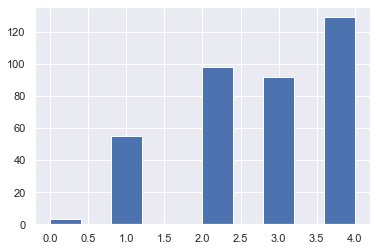

In [65]:
sm.medu.hist(bins=10)

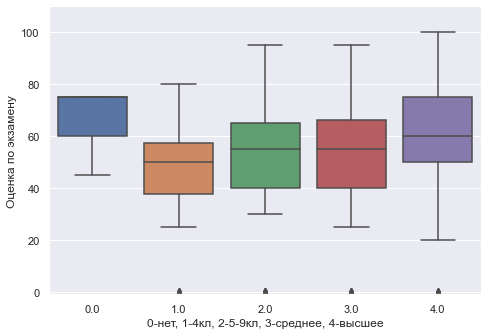

In [66]:
boxan(sm, 'medu', 'score', '0-нет, 1-4кл, 2-5-9кл, 3-среднее, 4-высшее')

Оу, ученики у которых мать без образования сдают тест на высокий бал. Может это выброс? Так как видно, что уровень образования влияет на оценку: чем выше образование - лучше оценки.

Посмотрим, может у них есть мотивация? или они получали доп образование. Из датасета выбираем "желание получить высшее образование" и "платные заняти по математике" как самые очевидные.

In [67]:
per_1 = sm.pivot_table(index=['higher', 'paid'],
                      columns=['medu'],
                      values=['score'],
                      aggfunc='max')
display(per_1)

score                         
medu          0.0   1.0   2.0   3.0    4.0
higher paid                               
no     no    45.0  60.0  65.0  60.0    NaN
yes    no    75.0  80.0  90.0  90.0  100.0
       yes   75.0  70.0  95.0  95.0   90.0

Мотивация - сила. Те, кто хотят высшее образование получают высокий бал (иногда даже без курсов по математике).

Проверим признак на стат. значимость (без Nan)


In [63]:
get_stat_dif1(sm, 'medu', met='score')

Cтатистически значимые различия для колонки medu не найдены


Пропуски (их всего 3) заменим модой.

In [68]:
sm.medu.describe() # Это описание числовой статистики, но в данном случае она нам подойдет, для моды и для медианы

count    377.000000
mean       2.766578
std        1.098184
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

In [69]:
sm.medu.fillna(4, inplace=True)

Вывод: Образование матери может влиять на оценку по математике, но с учетом допонительных факторов.

#########################################################################################################################

### Информация о столбце "fedu" (образование отца(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее))

In [70]:
empty_count(sm, 'fedu')

В колонке fedu - 6.1 % пропусков, это 23 значений Nan


In [71]:
sm.fedu.value_counts()

2.0     102
3.0      92
4.0      88
1.0      72
0.0       2
40.0      1
Name: fedu, dtype: int64

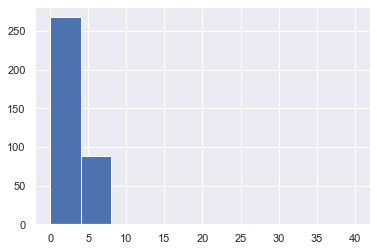

In [72]:
sm.fedu.hist(bins=10)

40 это явный выброс. Скорее ошибка и это либо 4 либо 0. Не будем гадать и удалим это значение.

In [73]:
sm.drop(sm[sm.fedu == 40].index, inplace=True)

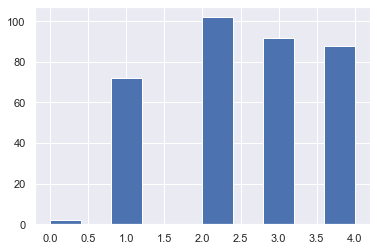

In [74]:
sm.fedu.hist(bins=10)

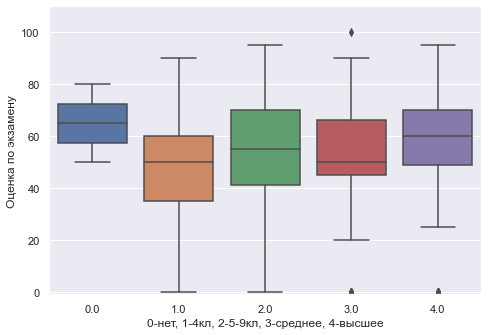

In [75]:
boxan(sm, 'fedu', 'score', '0-нет, 1-4кл, 2-5-9кл, 3-среднее, 4-высшее')

Похожая ситуация и с отцами без образования. Проверим на доп.занятия по математике. (По другим криетриям данных нет)

In [76]:
per_2 = sm.pivot_table(index=['paid'],
                      columns=['fedu'],
                      values=['score'],
                      aggfunc='max')
per_2

score                         
fedu   0.0   1.0   2.0    3.0   4.0
paid                               
no    50.0  90.0  95.0  100.0  95.0
yes   80.0  90.0  95.0   90.0  90.0

Малоинформативная сборка...

Проверка на стат.значимость (без Nan)


In [75]:
get_stat_dif1(sm, 'fedu', met='score')

Cтатистически значимые различия для колонки fedu не найдены


Пустых значений 23, заменим в данном случае медианой. И повторим тест

In [76]:
sm.fedu.describe() 

count    356.000000
mean       2.539326
std        1.088285
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

In [77]:
sm.fedu.fillna(3, inplace=True)

In [78]:
get_stat_dif2(sm, 'fedu', met='score')

Cтатистически значимые различия для колонки fedu не найдены


Зависимость образования отца явно не влияет на оценку.

Не будем использовать для модели.

#########################################################################################################################

### Информация о столбце "mjob" работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [78]:
empty_count(sm, 'mjob')

В колонке mjob - 4.5 % пропусков, это 17 значений Nan


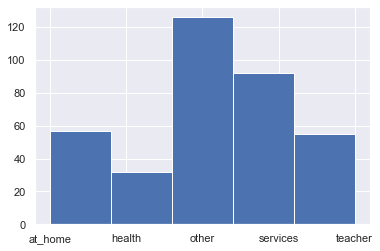

In [79]:
sm.mjob.hist(bins=5)

In [80]:
sm.mjob.value_counts()

other       126
services     92
at_home      57
teacher      55
health       32
Name: mjob, dtype: int64

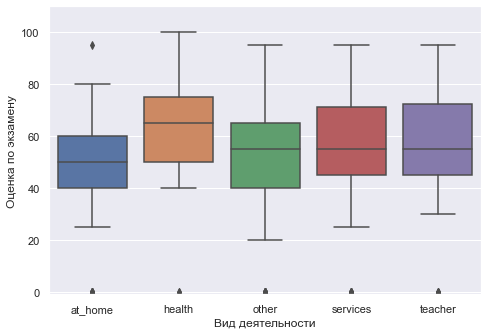

In [81]:
boxan(sm, 'mjob', 'score', 'Вид деятельности')


Медианное значение оценки для работы матери в сфере здравоохранения, выше чем, для других. Некоторая зависимость прослеживается. 


In [82]:
per_3 = sm.pivot_table(index=['higher', 'paid', 'famsup'],
                      columns=['mjob'],
                      values=['score'],
                      aggfunc='max')
per_3

score                              
mjob               at_home health other services teacher
higher paid famsup                                      
no     no   no        60.0    NaN   0.0     40.0     NaN
            yes       65.0    NaN   NaN     60.0     NaN
yes    no   no        80.0  100.0  95.0     90.0    95.0
            yes       50.0   70.0  80.0     90.0    90.0
       yes  no        50.0   75.0  75.0     90.0    90.0
            yes       95.0   90.0  75.0     95.0    80.0

Видно, что при желании получить вышку можно достигнуть такой оценки. Верхний выброс - допустимый.

Проверка на стат.значимость (без Nan)


In [84]:
get_stat_dif1(sm, 'mjob', met='score')

Cтатистически значимые различия для колонки mjob не найдены


Остаются пустые значения. Заменим модой, к тому же, мода здсь означает большинство профессий в целом.

In [83]:
desc_obj(sm.mjob)

Повторная проверка на стат. значимость

In [86]:
get_stat_dif2(sm, 'mjob', met='score')

Cтатистически значимые различия для колонки mjob не найдены


Вывод: визуальная зависимоть наблюдается, статистичекая нет. Профессия в сфере здравоохранения все-таки давольна узкая, не будем считать ее значимой. 

Не будем использовать для модели.

#########################################################################################################################

### Информация о столбце "fjob" работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [84]:
empty_count(sm, 'fjob')

В колонке fjob - 9.2 % пропусков, это 35 значений Nan


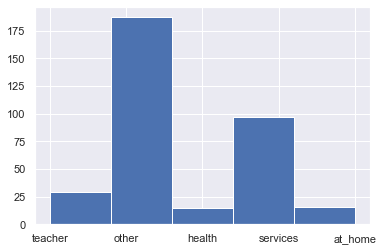

In [85]:
sm.fjob.hist(bins=5)

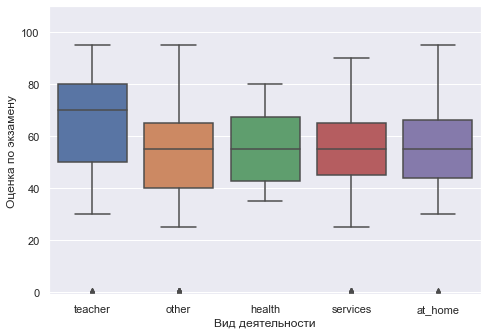

In [86]:
boxan(sm, 'fjob', 'score', 'Вид деятельности')

Если отец учитель, то получать плохие оценки не хорошо. А в остальном работа отца слабо влияет на оценку (наверно потому, что он всегда на работе)

Проверка на стат. значимость (без Nan)


In [90]:
get_stat_dif1(sm, 'fjob', met='score')

Cтатистически значимые различия для колонки fjob не найдены


Заменим пустые значения заменим модой.

In [87]:
desc_obj(sm.fjob)

In [93]:
get_stat_dif2(sm, 'fjob', met='score')

Cтатистически значимые различия для колонки fjob не найдены


Вывод: по аналогии с профессией матери, какая-то одна (пускай даже более-менее значимая визуально)не может быть значимой для целевой перменной. 

Не будем использовать для модели.

#########################################################################################################################

### Информация о столбце reason - причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [88]:
empty_count(sm, 'reason')

В колонке reason - 4.2 % пропусков, это 16 значений Nan


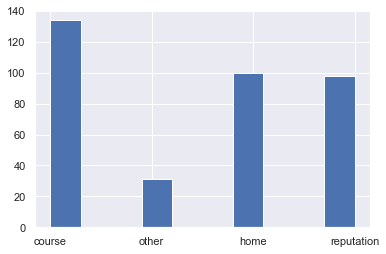

In [89]:
sm.reason.hist(bins=10)

In [90]:
sm.reason.value_counts()

course        134
home          100
reputation     98
other          31
Name: reason, dtype: int64

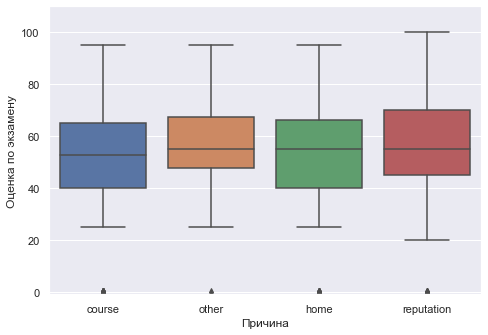

In [91]:
boxan(sm, 'reason', 'score', 'Причина')

Явной зависимости нет. Можно отметить, что разность в оценках у тех, кто выбрал школу рядом с домом немного ниже по сравнению с другими. А вот репутация школы и какие-то причины требуют стараний. 

Проверка на стат. значимость (без Nan)


In [98]:
get_stat_dif1(sm, 'reason', met='score')

Cтатистически значимые различия для колонки reason не найдены


Может это не верно, но я бы здсь пропуски заполнил 'other'. Это, как мне кажется, более логично. Если нет, напишите в фидбеке кaк лучше поступить тут. 

In [92]:
sm.reason.fillna('other', inplace=True)

In [100]:
get_stat_dif2(sm, 'reason', met='score')

Cтатистически значимые различия для колонки reason не найдены


Вывод: Ни визуальных, ни статистических различий нет. 

Не будем использовать для модели

#########################################################################################################################

### Информация о стобце guardian - опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [93]:
empty_count(sm, 'guardian')

В колонке guardian - 7.9 % пропусков, это 30 значений Nan


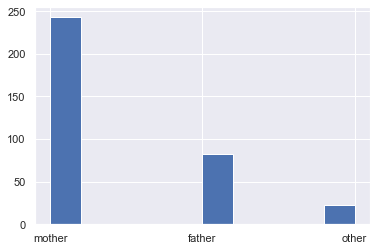

In [94]:
sm.guardian.hist(bins=10)

In [95]:
sm.guardian.value_counts()

mother    243
father     83
other      23
Name: guardian, dtype: int64

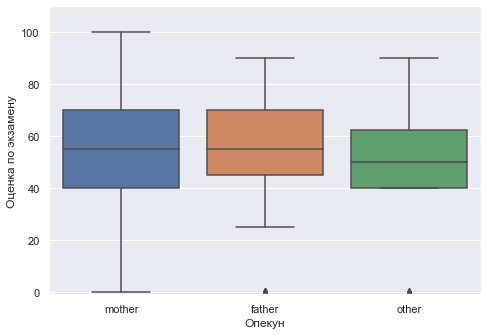

In [96]:
boxan(sm, 'guardian', 'score', 'Опекун')

Явной зависимсоти нет. Ну можно сказать, что у тех учеников у кого опекун отец большинство оценок побольше (ну отцы же строже), а больше результатов у матерей (оно и ясно, отцы же на работе). Другие опекуны - результат немного ниже, может это бабушка или дедушка. 

Проверка на стат. значимость (без Nan)


In [105]:
get_stat_dif1(sm, 'guardian', met='score')

Cтатистически значимые различия для колонки guardian не найдены


Пропусков почти 8% - заполнять такое - рисковать. Удалим столбец. (Но если бы заменял то на "mother").

In [97]:
sm.drop(labels = ['guardian'], axis=1, inplace=True)

#########################################################################################################################

### Информация о столбце  traveltime (1 (<15), 2 (15-30), 3 (30-60), 4 (>60), минут) 

In [98]:
empty_count(sm, 'traveltime')

В колонке traveltime - 6.9 % пропусков, это 26 значений Nan


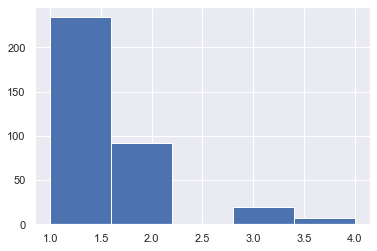

In [99]:
sm.traveltime.hist(bins=5)

In [100]:
sm.traveltime.value_counts()

1.0    234
2.0     92
3.0     20
4.0      7
Name: traveltime, dtype: int64

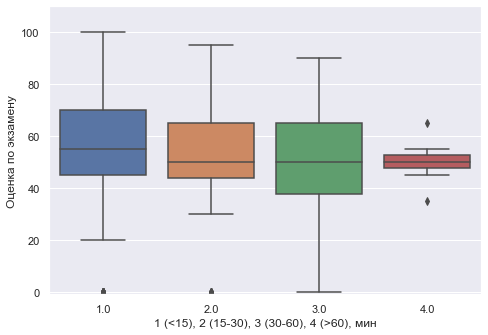

In [101]:
boxan(sm, 'traveltime', 'score', '1 (<15), 2 (15-30), 3 (30-60), 4 (>60), мин')

Время в пути до школы не оказывает особого влияния. Максимальная и минимальная оценка для пути более 60 минут оказалась вбросом. Но здесь, скорее всего нужно искать свзять с другими признаками. 

Проверка на стат. значимость (без Nan)



In [111]:
get_stat_dif1(sm, 'traveltime', met='score')

Cтатистически значимые различия для колонки traveltime не найдены


7% пустых значений, медиана почти равная... Заменим пустые значения на 2 и посмотрим, что изменится. На 2 потому, что большинство учеников в городе, выбор в пользу школы у дома на 2 месте, все не могут жить очень рядом со школой, оптимально около 30 минут.  

In [102]:
sm.traveltime.fillna(2, inplace=True)

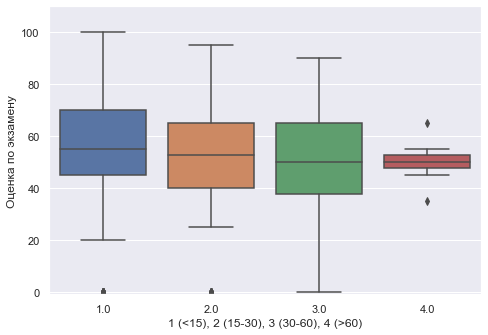

In [103]:
boxan(sm, 'traveltime', 'score', '1 (<15), 2 (15-30), 3 (30-60), 4 (>60)')

In [114]:
get_stat_dif2(sm, 'traveltime', met='score')

Cтатистически значимые различия для колонки traveltime не найдены


7% замены столбец "грязный". Удалим traveltime.

In [104]:
sm.drop(labels = ['traveltime'], axis=1, inplace=True)

#########################################################################################################################

### Информация о столбце studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов) и stadytime_g

In [105]:
empty_count(sm, 'studytime')

В колонке studytime - 1.1 % пропусков, это 4 значений Nan


In [106]:
empty_count(sm, 'studytime_s')

В колонке studytime_s - 1.1 % пропусков, это 4 значений Nan


In [107]:
print(sm.studytime.value_counts())
print(sm.studytime_s.value_counts())

2.0    187
1.0     99
3.0     62
4.0     27
Name: studytime, dtype: int64
-6.0     187
-3.0      99
-9.0      62
-12.0     27
Name: studytime_s, dtype: int64


Text(0, 0.5, 'Оценка по экзамену')

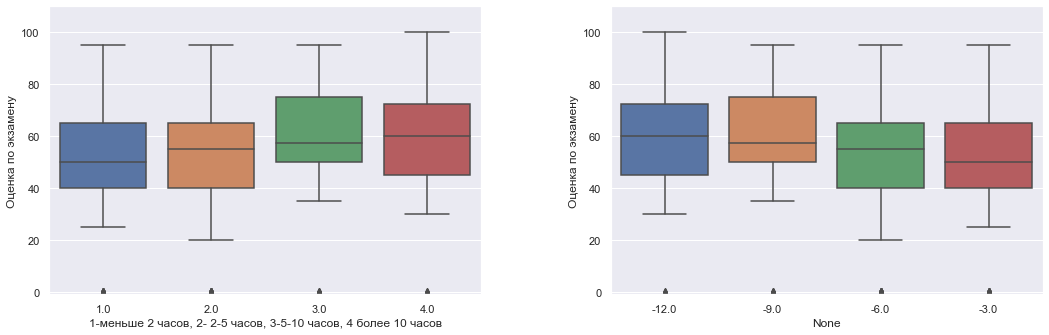

In [108]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(-1,110)
sns.boxplot(x = sm['studytime'], y = sm['score'])
axes.set_xlabel('1-меньше 2 часов, 2- 2-5 часов, 3-5-10 часов, 4 более 10 часов')
axes.set_ylabel('Оценка по экзамену')

axes2 = fig.add_axes([1.3, 0, 1, 1])
axes2.set_ylim(-1,110)
sns.boxplot(x = sm['studytime_s'], y = sm['score'])
axes2.set_xlabel('None')
axes2.set_ylabel('Оценка по экзамену')

Судя по графикам это зеркальное отображение колонки studytime. Вполне возможно, что это общее время учебы в неделю разбитое на (в школе/вне школы). С учетом того, что зависимость оценок сохранится, а мы точно не знаем, что означает studytime_s - удалим его. 

In [109]:
sm.drop(labels = ['studytime_s'], axis=1, inplace=True)

Проверка на стат. значимость (без Nan)

In [121]:
get_stat_dif1(sm, 'studytime', met='score')

Cтатистически значимые различия для колонки studytime не найдены


NaN заменим на моду. 

In [110]:
sm.studytime.fillna(2, inplace=True)

In [123]:
get_stat_dif2(sm, 'studytime', met='score')

Cтатистически значимые различия для колонки studytime не найдены


Вывод: Те, кто трантит на внеклассное обучение от 5 до 10 часов в неделю более успешны чем остальные. Наверное это оптимальное время. 

Не будем использовать для модели

#########################################################################################################################

### Информация о столбце failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [111]:
empty_count(sm, 'failures')

В колонке failures - 5.0 % пропусков, это 19 значений Nan


In [112]:
sm.failures.value_counts()

0.0    286
1.0     47
2.0     15
3.0     12
Name: failures, dtype: int64

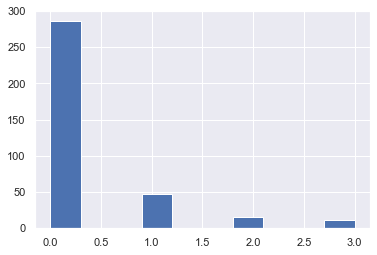

In [113]:
sm.failures.hist(bins=10)

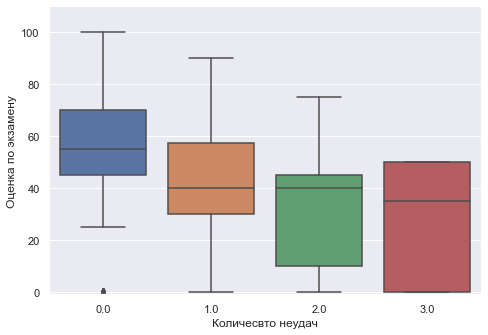

In [114]:
boxan(sm, 'failures', 'score', 'Количесвто неудач')

Очень сильное влияние на оценку по математике. Даже наличие 1 неудачи влияет на оценку. 

Позже проведем корреляционный тест, а пока оставим.


 Отсуствующие значения заменим модой.

In [115]:
sm.failures.fillna(0, inplace=True)

#########################################################################################################################

### Информация о колонках с 16 по 23 (все имеют значения Yes/No)

Ообъеденим их в отдельный датасет и поанализируем

In [116]:
sm_YN = sm[['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']]
for col in sm_YN.columns:
    empty_count(sm, col)


В колонке schoolsup - 2.1 % пропусков, это 8 значений Nan
В колонке famsup - 9.5 % пропусков, это 36 значений Nan
В колонке paid - 10.0 % пропусков, это 38 значений Nan
В колонке activities - 3.4 % пропусков, это 13 значений Nan
В колонке nursery - 4.0 % пропусков, это 15 значений Nan
В колонке higher - 4.7 % пропусков, это 18 значений Nan
В колонке internet - 9.0 % пропусков, это 34 значений Nan
В колонке romantic - 7.1 % пропусков, это 27 значений Nan


Пропусков очень много. До принятия решения о замены или удалении посмотрим на зависимость признака и целевой переменной. Для ускорения, проверку сделаем сразу по 4 признака.

In [117]:
sm_YN['score'] = sm.score # Добавим столбец с оценками 

no     323
yes     48
Name: schoolsup, dtype: int64
yes    214
no     129
Name: famsup, dtype: int64
no     193
yes    148
Name: paid, dtype: int64
yes    187
no     179
Name: activities, dtype: int64


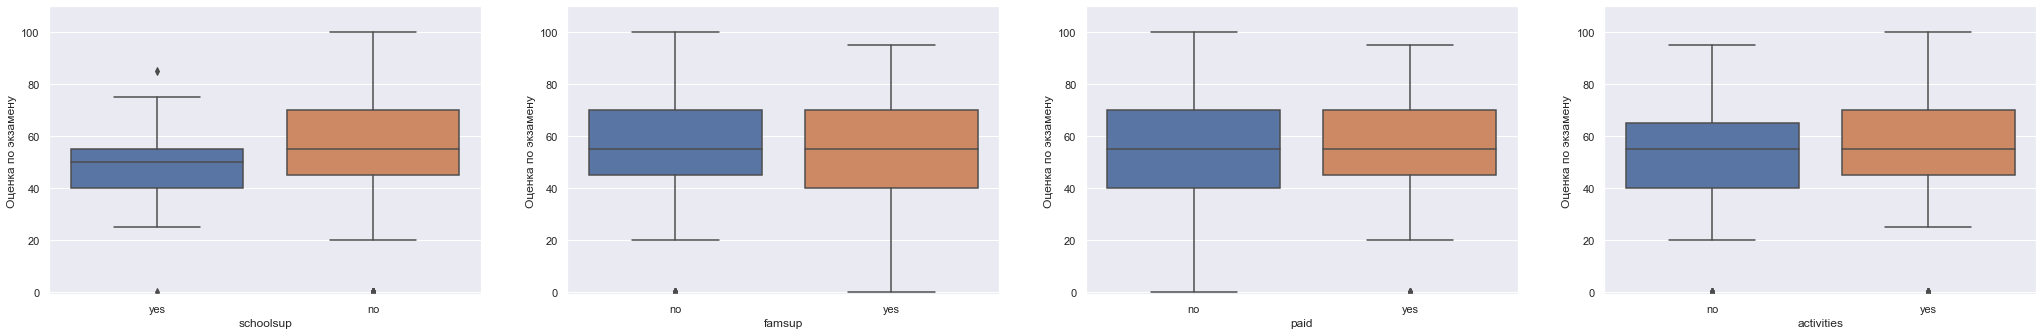

In [118]:
get_box(sm_YN,'schoolsup', 'famsup', 'paid', 'activities', 'score' )

1. Доп.образование в школе (schoolsup):
Странно, но результаты говорят, что если ученик не получает доп.образования в школе, он успшнее здает экзамен.

2. Доп. образование дома (famsup):
Пропусков 36 значений, явной зависимости нет. 
3. Платные курсы по математике:
Явной зависимости нет (хотя казалось бы...).

4. Дополнительные внеучебные занятия (activities):
Визуально прослеживается некоторая зависимость те ученики у которых такие занятия есть в большинстве получают выше медианы.


Проверим на стат. значимость

#### Внимание! Следующая ячейка ресурсоемкая

In [131]:
get_stat_dif1(sm, 'schoolsup', met='score')
get_stat_dif1(sm, 'famsup', met='score')
get_stat_dif1(sm, 'paid', met='score')
get_stat_dif1(sm, 'activities', met='score')

Cтатистически значимые различия для колонки schoolsup не найдены
Cтатистически значимые различия для колонки famsup не найдены
Cтатистически значимые различия для колонки paid не найдены
Cтатистически значимые различия для колонки activities не найдены


In [120]:
for col in ['schoolsup', 'famsup', 'paid', 'activities']:
    desc_obj(sm[col])

#### Внимание! Следующая ячейка ресурсоемкая

In [121]:
get_stat_dif2(sm, 'schoolsup', met='score')
get_stat_dif2(sm, 'famsup', met='score')
get_stat_dif2(sm, 'paid', met='score')
get_stat_dif2(sm, 'activities', met='score')

Cтатистически значимые различия для колонки schoolsup не найдены
Cтатистически значимые различия для колонки famsup не найдены
Cтатистически значимые различия для колонки paid не найдены
Cтатистически значимые различия для колонки activities не найдены


##### Часть 2

yes    291
no      73
Name: nursery, dtype: int64
yes    343
no      18
Name: higher, dtype: int64
yes    291
no      54
Name: internet, dtype: int64
no     232
yes    120
Name: romantic, dtype: int64


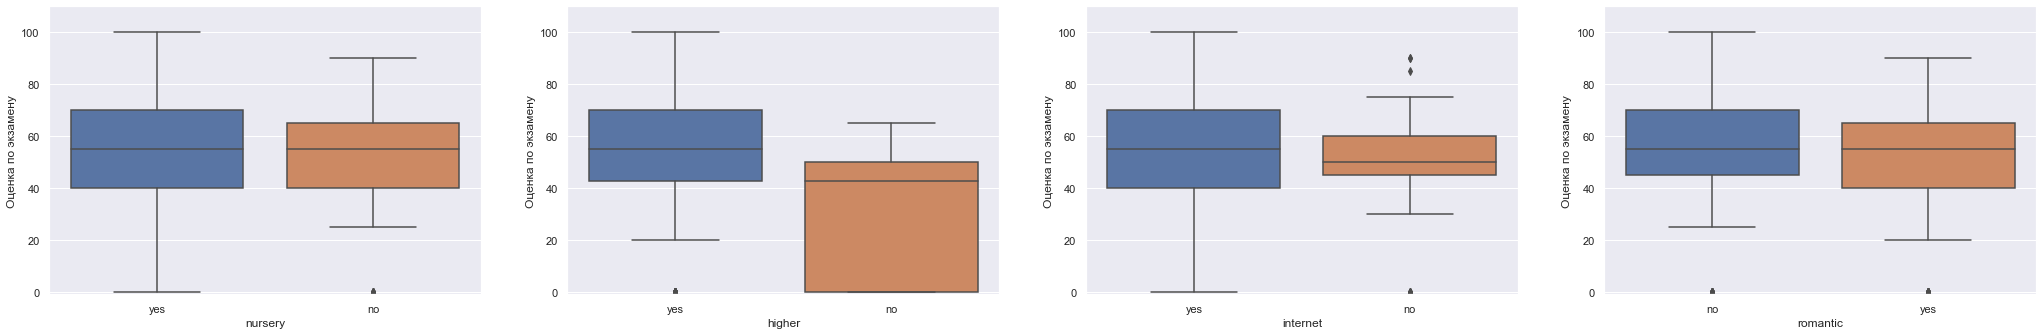

In [123]:
get_box(sm_YN, 'nursery', 'higher', 'internet', 'romantic', 'score')

1. Детский садик (nursery):
Визуальной зависимости нет.

2. Желание получить высшее образование (higher):
Визуальняа зависимость явная, кто этого не хочет получает по математике низкую оценку
. 
3. Интернет:
Явной зависимости нет.

4. Романтические отношения:
Визуально прослеживается некоторая зависимость те ученики у которых отношения есть в большинстве получают выше медианы.


Проверим стат. значимость

In [139]:
get_stat_dif1(sm, 'nursery', met='score')
get_stat_dif1(sm, 'higher', met='score')
get_stat_dif1(sm, 'internet', met='score')
get_stat_dif1(sm, 'romantic', met='score')

Cтатистически значимые различия для колонки nursery не найдены
Cтатистически значимые различия для колонки higher не найдены
Cтатистически значимые различия для колонки internet не найдены
Cтатистически значимые различия для колонки romantic не найдены


Заменим на моду

In [140]:
for col in ['nursery', 'higher', 'internet', 'romantic']:
    desc_obj(sm[col])

In [141]:
get_stat_dif2(sm, 'nursery', met='score')
get_stat_dif2(sm, 'higher', met='score')
get_stat_dif2(sm, 'internet', met='score')
get_stat_dif2(sm, 'romantic', met='score')

Cтатистически значимые различия для колонки nursery не найдены
Cтатистически значимые различия для колонки higher не найдены
Cтатистически значимые различия для колонки internet не найдены
Cтатистически значимые различия для колонки romantic не найдены


Вывод по метрикам 16-23:

Ни одна из метрик не является статистически значимой. Однако, визуально и логично предположить, что желание получить высшее образование может повлиять на оценку по математике. Поэтому колонку 'higher' я оставлю для модели.

#########################################################################################################################

### Информация о колонках с 24 по 27 (все имеют значения от 1 (очень плохо/мало)  до 5 (очень хорошо/много))

Ообъеденим их в отдельный датасет и поанализируем

In [125]:
sm_OtF = sm[['famrel', 'freetime', 'goout', 'health']]
for col in sm_OtF.columns:
    empty_count(sm, col)

В колонке famrel - 7.1 % пропусков, это 27 значений Nan
В колонке freetime - 2.1 % пропусков, это 8 значений Nan
В колонке goout - 1.8 % пропусков, это 7 значений Nan
В колонке health - 3.7 % пропусков, это 14 значений Nan


In [126]:
sm_OtF['score'] = sm.score # Добавим столбец с оценками 

 4.0    176
 5.0     90
 3.0     61
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64
3.0    150
4.0    107
2.0     61
5.0     36
1.0     17
Name: freetime, dtype: int64
3.0    124
2.0     98
4.0     78
5.0     49
1.0     23
Name: goout, dtype: int64
5.0    134
3.0     86
4.0     59
1.0     44
2.0     42
Name: health, dtype: int64


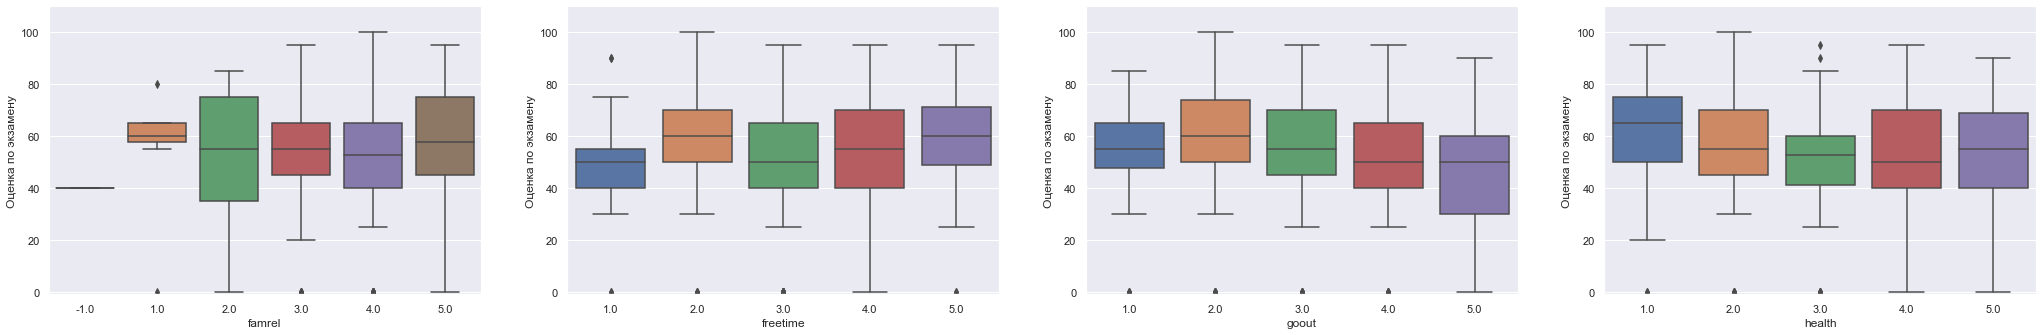

In [127]:
get_box(sm_OtF,'famrel', 'freetime', 'goout', 'health', 'score' )

1. Семейные отношения (famrel):
Значение равное -1 это выброс, удалим его. Плохие отношения - выше результат, но количесвто таких учеников мало. Наверное здесь играет роль мотивация к лучшей жизни через образование. 
Очень одинаково выглядят результаты как для значения famrel 2 (плохо) и 5 (очень хорошо). Это странно.


2. Свободное время после школ(freetime):
А здесь визуально прослеживается легкая зависимость. В целом чем больше свободного времени после школы, тем результат выше. 


3. Время проведенное с друзьями (goout):
Есть визуальная зависимость - чем больше времени тратистя на посиделки с друзьями тем оценка ниже. 


4. Текущее состояние здоровься (health):
Есть визуальная зависимость. У учеников с очень плохим здоровьем медиана выше, чем у других. А остальные степени состояния здоровья явной зависимости не вызывают.


In [128]:
# Удаление выброса в колонке famrel
sm.drop(sm[sm.famrel == -1].index, inplace=True)

Проверим на стат. значимость

In [151]:
for col in ['famrel', 'freetime', 'goout', 'health']:
    get_stat_dif1(sm, col, met='score')

Cтатистически значимые различия для колонки famrel не найдены
Cтатистически значимые различия для колонки freetime не найдены
Cтатистически значимые различия для колонки goout не найдены
Cтатистически значимые различия для колонки health не найдены


In [129]:
for col in ['famrel', 'freetime', 'goout', 'health']:
    rew_num_moda(sm[col])

In [158]:
for col in ['famrel', 'freetime', 'goout', 'health']:
    get_stat_dif2(sm, col, met='score')

Cтатистически значимые различия для колонки famrel не найдены
Cтатистически значимые различия для колонки freetime не найдены
Cтатистически значимые различия для колонки goout не найдены
Cтатистически значимые различия для колонки health не найдены


Что ж... Ничего из этого не имеет математически подтвержденной зависимости с величиной оценки по математике. 
Не будем использовать для модели

#########################################################################################################################

### Информация о столбце absences количесвто пропущенных занятий.

In [131]:
empty_count(sm, 'absences')

В колонке absences - 2.6 % пропусков, это 10 значений Nan


Числовой стобец. Посмотрим распределение, выбросы

In [132]:
sm.absences.nunique()

35

In [133]:
sm.absences.describe()

count    368.000000
mean       7.211957
std       23.882516
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

385! Выброс скорее всего.

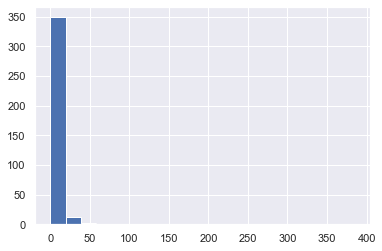

In [134]:
sm.absences.hist(bins=20)

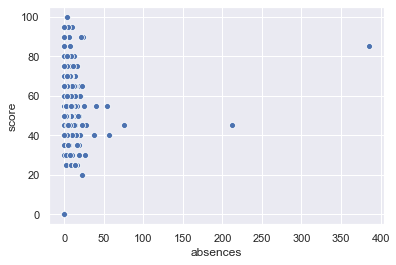

In [135]:
sm_a = sm[['absences', 'score']]
sns.scatterplot(data=sm_a, x="absences", y="score");

Больше 50-ти пропусков будем считать выбросами. Уберм их, но пока, что в датасете sm_a

In [136]:
sm_a.drop(sm_a[sm_a.absences >50].index, inplace=True)

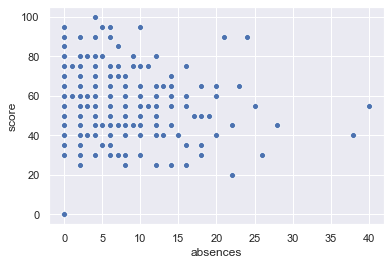

In [137]:
sns.scatterplot(data=sm_a, x="absences", y="score");

Более 30-то пропусков тоже выглядит как выброс.

In [138]:
sm_a = sm_a.drop(sm_a[sm_a.absences >30].index)

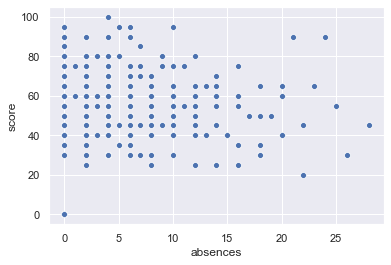

In [139]:
sns.scatterplot(data=sm_a, x="absences", y="score");

In [140]:
sm_b = sm_a.astype('Int64') # Для лучшего отображения чисел на графике.

In [141]:
sm_a = sm_a.sort_values(by='absences')
sm_b = sm_b.sort_values(by='absences') # Отсротирум по количеству пропусков. Для боксплота.

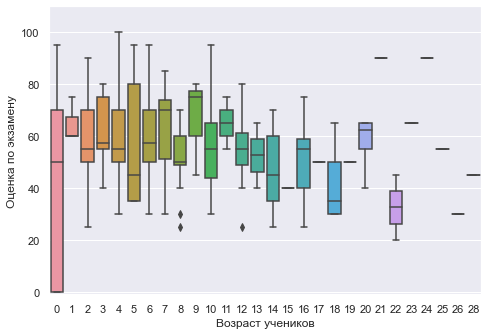

In [142]:
boxan(sm_b, 'absences', 'score', 'Возраст учеников')

In [143]:
sm_a[sm_a['absences'] == 20]

,absences,score
237,20.0,60.0
118,20.0,40.0
304,20.0,65.0
311,20.0,65.0


1. Мы видим несколько значений явно выбросы это 21 и 24 пропущеных занятий - получена очень высокая оценка.
2. 23 и 25 пропущеных тоже лежат выше большинства медиан. 

3. Ученики пропустивышие 20 занятий (это 4 значения) получили подозрительно высокие оценки, чем у учеников с 18 и 22 пропущенными 


Удалим все, что больше 19 пропущных уроков, кроме 21 пропущенного урока.

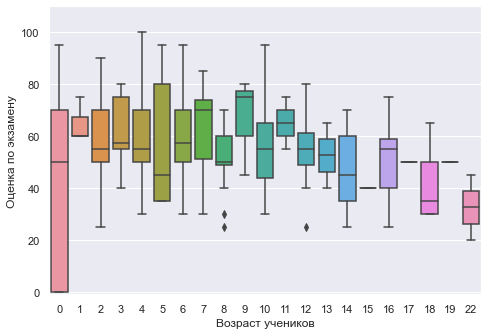

In [144]:
sm_a = sm_a.drop(sm_a[(sm_a.absences>22)|(sm.absences==20)|(sm.absences==21)].index)
#sm_a = sm_a.drop(sm_a[sm_a.absences==20].index)
#sm_a = sm_a.drop(sm_a[sm_a.absences==21].index) # Так более читаемо чем в одной строке, хотя может это не правильно.
sm_a = sm_a.astype('Int64')
boxan(sm_a, 'absences', 'score', 'Возраст учеников')

Теперь значения лежат в некоторой зависимости. Немного поправим главный датасет, и заменим отсуствующие значения медианой.

In [145]:
sm.drop(sm[sm.absences>22].index, inplace=True)
sm.drop(sm[(sm.absences==20)|(sm.absences==20)].index, inplace=True)

In [146]:
sm.absences.describe()

count    352.000000
mean       4.511364
std        4.956780
min        0.000000
25%        0.000000
50%        3.000000
75%        7.000000
max       22.000000
Name: absences, dtype: float64

In [147]:
sm.absences.fillna(3, inplace=True)

#########################################################################################################################

### Корреляционные тесты количественных переменных

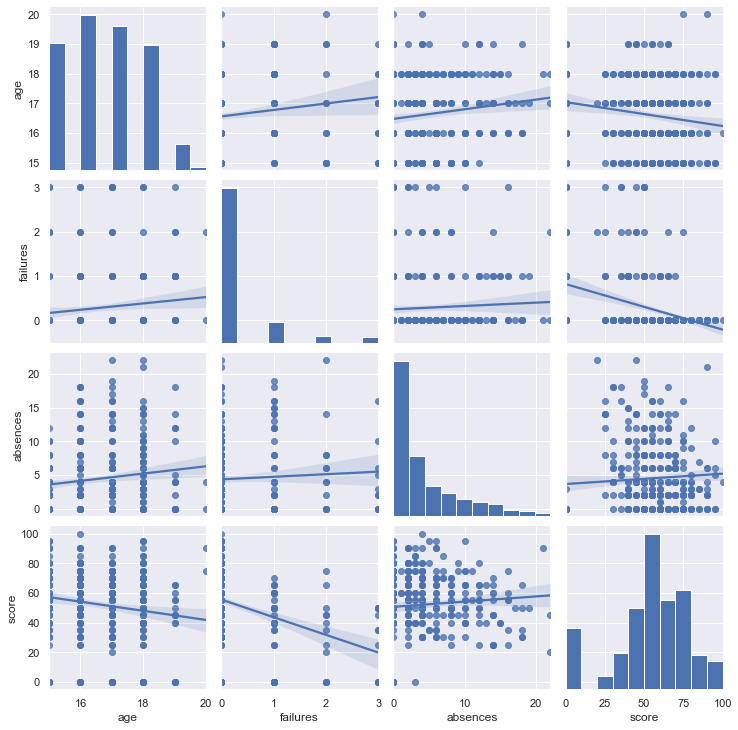

In [148]:
sm_corr = sm[['age', 'failures', 'absences', 'score']]
sns.pairplot(sm_corr, kind='reg')

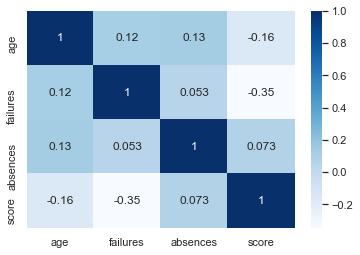

In [149]:
sns.heatmap(sm_corr.corr(), cmap='Blues', annot=True)

Все 3 переменные слабоскоррелированы с оценкой по математике. 

Возраст (age): Заметно снижение оценки с увеличением возраста. (Может увеличивается сложность заданий по математике и в более старших классах уже не так просто получить высокую оценку)

Внеучебные неудачи (failures): Самая сильная корреляция из представленных. Видно, что чем больше неудач (знать бы еще какого они рода) тем более низкая оценка по математике. 

Пропущенные занятия (absences): Вот тут неожиданно. Единственно положительная корреляци. Чем больше занятий пропущено, тем выше оценка. Может у них было домашнее обучение или репетиторство вместо уроков.

Вывод:
Все 3 метрики будем использовать для модели

Проверка:

In [150]:
sm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 394
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      362 non-null    object 
 1   sex         362 non-null    object 
 2   age         362 non-null    int64  
 3   address     362 non-null    object 
 4   famsize     362 non-null    object 
 5   medu        362 non-null    float64
 6   fedu        362 non-null    float64
 7   mjob        362 non-null    object 
 8   fjob        362 non-null    object 
 9   reason      362 non-null    object 
 10  studytime   362 non-null    float64
 11  failures    362 non-null    float64
 12  schoolsup   362 non-null    object 
 13  famsup      362 non-null    object 
 14  paid        362 non-null    object 
 15  activities  362 non-null    object 
 16  nursery     347 non-null    object 
 17  higher      345 non-null    object 
 18  internet    330 non-null    object 
 19  romantic    335 non-null    o

Из 395 строк было удалено 33 строки (окло 8.5 %) 

# Общий вывод:

- В данных присутсвовали пропуски, в некоторых случаях достигающие 11% от всего столбца. Для категориальных данных пропуски заполнялись модой, после проверки на статистическую значимость. Проверка на стат. значимость проводилась дважды (до и после замены пропусков). У количественных данных пропуски также заменялись модой или средним. Общее число количественных данных намного меньше по сравнению с категориальными.

- Выброс равный 0 оценки - считается допустимым и не удалялся. (Но тут вопрос к ментору) 

- Среди категориальных переменных, с помощью теста на стат. значимость, не было обнаружено ни одной зависимости. Однако, я бы выделил признак 'higher', где визуально есть некоторая зависимость и скорее всего он оказывает влияние на оценку по математике.
            

- Признаки, которые войдут в датасет для построения модели выбраны следующие:
           
      1 'age'
      2 'failures'
      3 'absences'
      4 'higher'
Итоговый датасет:

In [151]:
sm_for_model = sm.loc[:, ['age', 'failures', 'absences', 'higher']]
sm_for_model.head()
                      

,age,failures,absences,higher
0,18,0.0,6.0,yes
1,17,0.0,4.0,yes
2,15,3.0,10.0,yes
3,15,0.0,2.0,yes
4,16,0.0,4.0,yes


#########################################################################################################################

#########################################################################################################################

### Вопросы ментору:

#### 1. Что делать с 0 у score?

Везде видно, что 0 считается выбросом. И сначла хочется его удлаить. Но это целевая метрика! И как говорили на вебенаре "если выброс в пределах возможных значенйи (а проваленый тест это какая-никакая, но оценка), то удалять его не нужно"

Что означает 0? Тест не сдавался или набрано меньше чем минимум (судя по всему 20)?
Если не сдавался, то эти данные нам мешают, но таких значений с 0 много и зачем их тогда добавлять в датасет изначально.

Тут приходит мысль, что в 0 скрыты все значения баллов до 20. (Судя по всему 5, 10, 15), просто если успех это от 20 то все, что меньше имеет только одно значение - ТЕСТ НЕ СДАН. 

Можно ли в такой ситуации сделать так:

Заменить все значения с 0 на, например значение 10? Графики будут более информативны.

Все-таки как тут лучше поступить?


In [153]:
sm_10 = pd.read_csv('stud_math.csv')

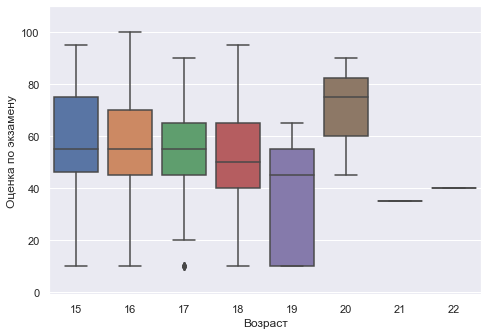

In [161]:
sm_10 = sm_10[['age', 'score']]
sm_10.score.fillna(0, inplace=True)
sm_10.score.replace({0:10}, inplace=True)
boxan(sm_10, 'age', 'score', 'Возраст')

#### 2. Что делать если визуально есть ЯВНАЯ зависимость, а стат. тест показывает, что ее нет?

Как например колонка про высшее образование. И есть логика в этом.

#### 3. В каких случаях нужно переводить бинарные признаки в 0 и 1? Нужно ли это делать всегда, когда такие попались в датасете?
 

#### 4. Какой тип графиков лучше всего подходит для визуального анализа бинарных (или любых категориальных) признаков? 

#### 5. Сравнение зависимости одного признака с другим, если ни один из них не являестя целевой переменной имеет смысл? 

Или это уже выходит за рамки EDA? Просто можно же найти зависимость одного признака на другой, который в свою очередь влияет на целевую переменную. То есть, влияние одного признака на целевую переменную не напрямую, а через другой признак. 

#### Спасибо.